The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [3]:
# TODO : import the dataset

ab_df = pd.read_csv('AB_Test_Results.csv')

In [4]:
# TODO : take a quick look at the data
def explore_dataframe(df):
    print("=== Overview of the first lines ===")
    print(ab_df.head(), "\n")

    print("=== Column and type info ===")
    print(ab_df.info(), "\n")

    print("=== Descriptive statistics ===")
    print(ab_df.describe(include="all"), "\n")

    print("=== Missing values ​​per column ===")
    print(ab_df.isna().sum(), "\n")

    print("=== Number of duplicates ===")
    print(ab_df.duplicated().sum(), "\n")

    print("=== Number of unique values ​​per column ===")
    print(ab_df.nunique(), "\n")

    print("=== Overview of the last lines ===")
    print(ab_df.tail(), "\n")

explore_dataframe(ab_df)


=== Overview of the first lines ===
   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0 

=== Column and type info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None 

=== Descriptive statistics ===
             USER_ID VARIANT_NAME       REVENUE
count   10000.000000        10000  10000.000000
unique           NaN            2           NaN
top              NaN      variant           NaN
freq             NaN         5016           NaN
mean     4981.080200          NaN      0.099447
std      2890.590115   

Let's see if there are users who have two A/B test groups

In [5]:
# TODO : Look at the distribution of the number of unique groups for each user
ab_df['unique_groups_per_user'] = ab_df.groupby('USER_ID')['VARIANT_NAME'].transform('nunique')
ab_df.head(15)


,USER_ID,VARIANT_NAME,REVENUE,unique_groups_per_user
0,737,variant,0.00,1
1,2423,control,0.00,2
2,9411,control,0.00,2
3,7311,control,0.00,2
4,6174,variant,0.00,1
5,2380,variant,0.00,1
6,2849,control,0.00,2
7,9168,control,0.00,1
8,6205,variant,0.00,2
9,7548,control,0.00,1


In [6]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms

relative_distribution = ab_df['unique_groups_per_user'].value_counts(normalize=True)


relative_distribution = relative_distribution.sort_index() * 100

relative_distribution


,proportion
unique_groups_per_user,
1,60.7
2,39.3


What can you observe ? Should we exclude these users ? Why ?

As we can see 39.3% of users are associated with two unique groups.

In A/B testing, each user is assumed to belong to a single group (variant or control) to ensure fair comparisons. If a user is exposed to multiple groups (here, 39.3% of users), this can bias the results

It is preferable to exclude users exposed to multiple groups, for reasons of data integrity and test validity

In [7]:
# TODO : users have 1 A/B test group ?

filter_ab_df = ab_df[ab_df['unique_groups_per_user'] == 1]
filter_ab_df.sample(10)


# TODO : Take only these users


,USER_ID,VARIANT_NAME,REVENUE,unique_groups_per_user
6658,8791,variant,0.0,1
2210,6270,variant,0.0,1
8891,1059,control,0.0,1
934,8330,control,0.0,1
6175,4954,control,0.0,1
6207,2026,control,0.0,1
1997,5613,variant,0.0,1
3129,4025,variant,0.0,1
4523,7251,variant,0.0,1
1301,6390,variant,0.0,1


In [8]:
# TODO : Leave only records with users with the 1st ab test group
# TODO : Check that the number of users matches what it was before the exception
original_count = ab_df.shape[0]
filtered_count = filter_ab_df.shape[0]
print(original_count)
print(filtered_count)




10000
6070


Let's see how the data is distributed

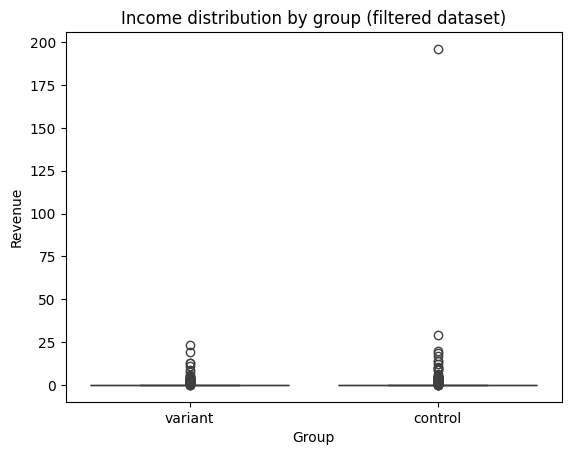

In [9]:
# TODO : Check how the data is distributed using a box plot
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=filter_ab_df)
plt.title("Income distribution by group (filtered dataset)")
plt.xlabel("Group")
plt.ylabel("Revenue")
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [10]:
# TODO : Sort these revenue values in descending order
filter_ab_df = filter_ab_df.sort_values(by='REVENUE', ascending=False)
filter_ab_df.head(10)

,USER_ID,VARIANT_NAME,REVENUE,unique_groups_per_user
1437,3342,control,196.01,1
8168,2166,control,29.32,1
2482,7356,variant,23.04,1
6412,1053,control,20.07,1
5217,3684,variant,19.47,1
5530,282,control,18.56,1
758,4445,control,17.05,1
4031,2059,control,14.24,1
9019,1973,control,14.07,1
4561,4966,variant,12.99,1


In [11]:
# TODO : See if user 3342 had other events with a strong outlier

other_events = filter_ab_df[filter_ab_df['USER_ID'] == 3342]
other_events

,USER_ID,VARIANT_NAME,REVENUE,unique_groups_per_user
1437,3342,control,196.01,1


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

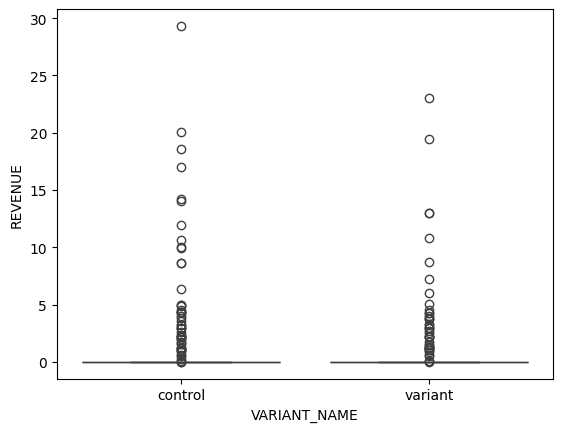

In [12]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
filter_ab_df = filter_ab_df[filter_ab_df['USER_ID'] != 3342]
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=filter_ab_df)


What can you say about the users and their purchases ?

The majority of points are concentrated near zero, indicating that most users make purchases with low amounts or make no purchases at all.

There are several points (outliers) above the whiskers for both groups (control and variant).



In [13]:
# TODO : Check if there are users who have records with zero and positive revenue
zero_revenue_users = set(filter_ab_df[filter_ab_df['REVENUE'] == 0]['USER_ID'])
positive_revenue_users = set(filter_ab_df[filter_ab_df['REVENUE'] > 0]['USER_ID'])

users_with_zero_and_positive_revenue = zero_revenue_users.intersection(positive_revenue_users)

for user in users_with_zero_and_positive_revenue:
    print(f"User {user} has records with zero and positive revenue.")

User 3331 has records with zero and positive revenue.
User 2181 has records with zero and positive revenue.
User 8583 has records with zero and positive revenue.
User 1035 has records with zero and positive revenue.
User 5900 has records with zero and positive revenue.
User 5134 has records with zero and positive revenue.
User 4113 has records with zero and positive revenue.
User 1939 has records with zero and positive revenue.
User 282 has records with zero and positive revenue.
User 1053 has records with zero and positive revenue.
User 6429 has records with zero and positive revenue.
User 9766 has records with zero and positive revenue.
User 169 has records with zero and positive revenue.
User 8886 has records with zero and positive revenue.
User 4918 has records with zero and positive revenue.
User 1339 has records with zero and positive revenue.
User 443 has records with zero and positive revenue.
User 7613 has records with zero and positive revenue.
User 6207 has records with zero

Can a user have records with both zero and positive revenue ?

normaly no.

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.

but if we assume that the records are user's visits and the experiment unit is users then yes we can have both user with negativ and positiv revenue


In [14]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
aggregated_revenue_df = filter_ab_df.groupby(['USER_ID', 'VARIANT_NAME'])['REVENUE'].sum().reset_index()
aggregated_revenue_df = aggregated_revenue_df.sort_values(by=['REVENUE'], ascending=False)
aggregated_revenue_df.columns = ['USER_ID', 'GROUP', 'TOTAL_REVENUE']
aggregated_revenue_df = aggregated_revenue_df.reset_index(drop=True)
aggregated_revenue_df.head(10)


,USER_ID,GROUP,TOTAL_REVENUE
0,2166,control,29.32
1,7356,variant,23.04
2,1053,control,20.07
3,3684,variant,19.47
4,282,control,18.56
5,4445,control,17.05
6,2059,control,14.24
7,1973,control,14.07
8,6294,variant,12.99
9,4966,variant,12.99


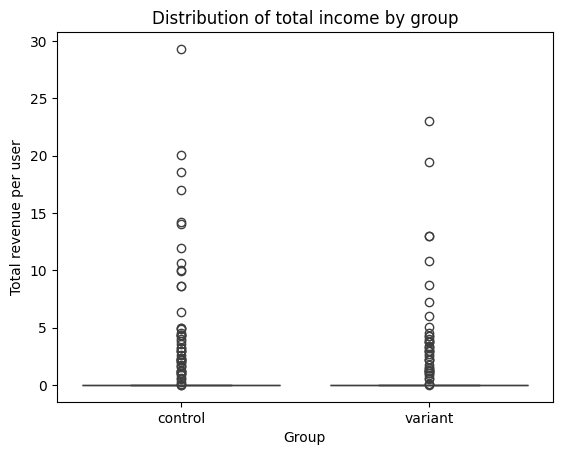

In [15]:
# TODO : Visualize the resulting distribution of the data again.
sns.boxplot(x='GROUP', y='TOTAL_REVENUE', data=aggregated_revenue_df)
plt.title("Distribution of total income by group")
plt.xlabel("Group")
plt.ylabel("Total revenue per user")
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [16]:
# TODO : get metrics by groups
group_metrics = aggregated_revenue_df.groupby('GROUP')['TOTAL_REVENUE'].describe()
print(group_metrics)


# TODO : create two additional metrics to see relative changes
group_metrics = aggregated_revenue_df.groupby('GROUP')['TOTAL_REVENUE'].agg(['sum', 'mean']).reset_index()
group_metrics.columns = ['GROUP', 'TOTAL_REVENUE', 'MEAN_REVENUE']

control_metrics = group_metrics[group_metrics['GROUP'] == 'control']
variant_metrics = group_metrics[group_metrics['GROUP'] == 'variant']

mean_revenue_change = (
    (variant_metrics['MEAN_REVENUE'].values[0] - control_metrics['MEAN_REVENUE'].values[0]) /
    control_metrics['MEAN_REVENUE'].values[0]
) * 100

total_revenue_ratio = (
    variant_metrics['TOTAL_REVENUE'].values[0] / control_metrics['TOTAL_REVENUE'].values[0]
)
print(f"Mean Revenue Change (%): {mean_revenue_change:.2f}%")
print(f"Total Revenue Ratio (Variant/Control): {total_revenue_ratio:.2f}")

# TODO : add them to the rest of the metrics in a separate group
additional_metrics = pd.DataFrame({
    'Metric': ['Mean Revenue Change (%)', 'Total Revenue Ratio (Variant/Control)'],
    'Value': [mean_revenue_change, total_revenue_ratio]
})

additional_metrics.head()


          count      mean       std  min  25%  50%  75%    max
GROUP                                                         
control  2389.0  0.114923  1.162495  0.0  0.0  0.0  0.0  29.32
variant  2393.0  0.074935  0.858207  0.0  0.0  0.0  0.0  23.04
Mean Revenue Change (%): -34.80%
Total Revenue Ratio (Variant/Control): 0.65


,Metric,Value
0,Mean Revenue Change (%),-34.795025
1,Total Revenue Ratio (Variant/Control),0.653142


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

Let's look at the distributions of all and only paying users

In [19]:
aggregated_revenue_df.head(10)

,USER_ID,GROUP,TOTAL_REVENUE
0,2166,control,29.32
1,7356,variant,23.04
2,1053,control,20.07
3,3684,variant,19.47
4,282,control,18.56
5,4445,control,17.05
6,2059,control,14.24
7,1973,control,14.07
8,6294,variant,12.99
9,4966,variant,12.99


<ipython-input-24-2d6193609d37>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(aggregated_revenue_df.loc[aggregated_revenue_df['GROUP'] == 'control', 'TOTAL_REVENUE'], ax = axes[0], label='control')
<ipython-input-24-2d6193609d37>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(aggregated_rev

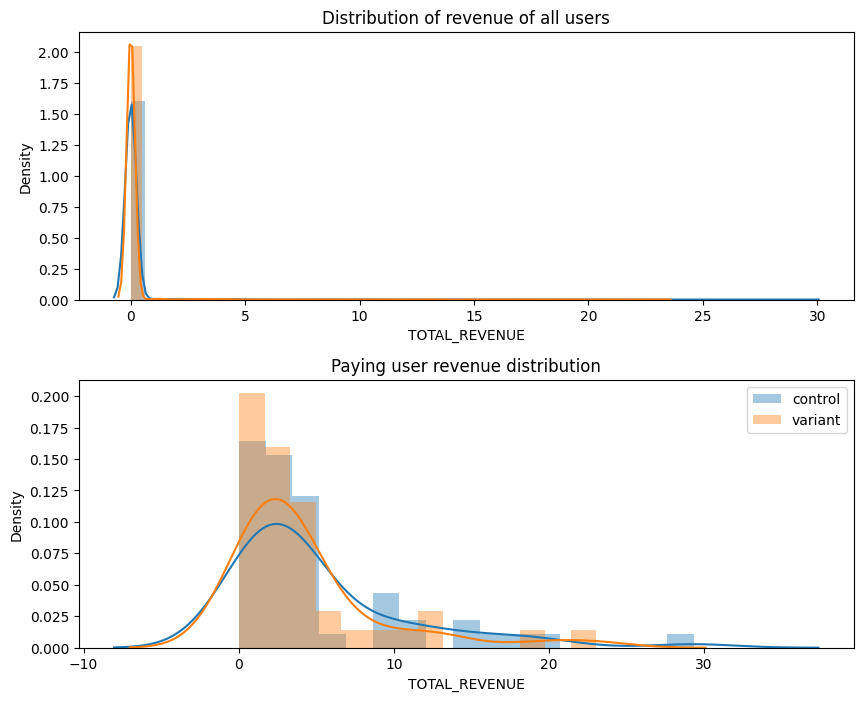

In [24]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(aggregated_revenue_df.loc[aggregated_revenue_df['GROUP'] == 'control', 'TOTAL_REVENUE'], ax = axes[0], label='control')
sns.distplot(aggregated_revenue_df.loc[aggregated_revenue_df['GROUP'] == 'variant', 'TOTAL_REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(aggregated_revenue_df.loc[(aggregated_revenue_df['GROUP'] == 'control') & (aggregated_revenue_df['TOTAL_REVENUE'] > 0), 'TOTAL_REVENUE'], ax = axes[1], label='control' )
sns.distplot(aggregated_revenue_df.loc[(aggregated_revenue_df['GROUP'] == 'variant') & (aggregated_revenue_df['TOTAL_REVENUE'] > 0), 'TOTAL_REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [ ]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [ ]:
(df['REVENUE'] == 0).value_counts()

In [ ]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users

In [ ]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
